# Biomedical Data Bases, 2021-2022
### Relational databases
These are notes by prof. Davide Salomoni (d.salomoni@unibo.it) for the Biomedical Data Base course at the University of Bologna, academic year 2020-2021.

## SQLite
### Import sqlite3 and connect to the database

In [1]:
import sqlite3 as sql

# create a connection to the DB
# if the DB does not exist, it will be created
# verify that after this statement you now have the DB file on your system
conn = sql.connect('sqlite_demo.db')

In [2]:
# get a cursor to the connection
cur = conn.cursor()

### Create some tables and perform basic operations

In [3]:
# create two tables
cur.execute('''DROP TABLE IF EXISTS Students;''')
cur.execute('''CREATE TABLE Students(
                id INTEGER PRIMARY KEY,
                first_name TEXT NOT NULL,
                last_name TEXT NOT NULL,
                age INTEGER,
                email TEXT NOT NULL UNIQUE);
            ''')
cur.execute('''DROP TABLE IF EXISTS Student_courses;''')
cur.execute('''CREATE TABLE Student_courses(
                id INTEGER PRIMARY KEY,
                student_id INTEGER NOT NULL,
                course_id INTEGER,
                course_name TEXT NOT NULL,
                FOREIGN KEY(student_id) REFERENCES Student(id));
            ''')

# commit the changes to the DB
conn.commit()

In [4]:
# insert a row
cur.execute('''INSERT INTO Students
                VALUES (1, 'John', 'Doe', 21, 'john@doe.com');''')

In [5]:
# insert the _same_ row again. It should fail because id is a primary key.
cur.execute('''INSERT INTO Students
                VALUES (1, 'John', 'Doe', 21, 'john@doe.com');''')

IntegrityError: UNIQUE constraint failed: Students.id

In [6]:
# delete a record
cur.execute('''DELETE FROM Students WHERE id=1;''')

In [7]:
# create a tuple with the students
the_students = (
    (1, 'John', 'Doe', 21, 'john@doe.com'),
    (2, 'Alice', 'Doe', 22, 'alice@doe.com'),
    (3, 'Rose', 'Short', 21, 'rose@short.com')
)

# and a tuple with the courses they follow
the_courses = (
    (1, 3, 102, 'BDB'),
    (2, 1, 110, 'BDP1'),
    (3, 3, 110, 'BDP1')
)

# now use executemany to insert the values into the tables
cur.executemany('''INSERT INTO Students VALUES(?, ?, ?, ?, ?)''', the_students)
cur.executemany('''INSERT INTO Student_courses VALUES(?, ?, ?, ?)''', the_courses)

### Remember to call commit() after altering the DB
Until you call commit() on a certain connection, the operations you have performed are *not* written to disk. So, make sure you call commit() to end a transaction.

In [8]:
conn.commit()

### Query SQLite

In [9]:
cur.execute('SELECT * FROM Students')

In [10]:
print(cur.fetchall())

[(1, 'John', 'Doe', 21, 'john@doe.com'), (2, 'Alice', 'Doe', 22, 'alice@doe.com'), (3, 'Rose', 'Short', 21, 'rose@short.com')]


In [11]:
cur.execute('SELECT * FROM Student_courses')

In [12]:
print(cur.fetchall())

[(1, 3, 102, 'BDB'), (2, 1, 110, 'BDP1'), (3, 3, 110, 'BDP1')]


In [13]:
# select records based on some condition
cur.execute('SELECT * FROM Students WHERE id=3')
print(cur.fetchall())

[(3, 'Rose', 'Short', 21, 'rose@short.com')]


### Closing the connection
Remember to close a connection when you are done operating with the DB.

In [14]:
conn.close()

### Catching exceptions

In [15]:
# a better way to handle sqlite calls in python
try:
    conn = sql.connect('sqlite_demo.db')
    cur = conn.cursor()
    print("Connection successful")
    # put here all your DB processing stuff - do not forget to commit after changes to the db
    cur.execute('SELECT * FROM Students')
    print(cur.fetchall())
    # closing a _cursor_ is a good idea to reclaim memory
    cur.close()
except sql.Error as error:
    print("Error in SQLite:", error)
finally:
    # whatever happens, close the connection
    conn.close()

Connection successful
[(1, 'John', 'Doe', 21, 'john@doe.com'), (2, 'Alice', 'Doe', 22, 'alice@doe.com'), (3, 'Rose', 'Short', 21, 'rose@short.com')]


## Perform data analysis with pandas

First, copy the sample data set from GitHub and to put it in your bdb directory.

### Import the SQLite DB into a pandas dataframe

In [16]:
import pandas as pd
conn = sql.connect('gubbio_env_2018.sqlite')
df = pd.read_sql_query('SELECT * FROM gubbio', conn)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    8760 non-null   int64  
 1   month   8760 non-null   int64  
 2   day     8760 non-null   int64  
 3   hour    8760 non-null   int64  
 4   NO2     8760 non-null   float64
 5   O3      8760 non-null   float64
 6   PM10    8760 non-null   float64
 7   PM25    8760 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 547.6 KB


In [17]:
df.head()

year  month  day  hour         NO2         O3  PM10      PM25
0  2018      1    1     1   20.595107  12.170429  23.5  11.74986
1  2018      1    1     2 -999.000000  11.423779  23.5  11.74986
2  2018      1    1     3   24.490770   8.431690  23.5  11.74986
3  2018      1    1     4   20.789195  10.564102  23.5  11.74986
4  2018      1    1     5   15.802340  16.109878  23.5  11.74986

### Using df.loc[]

In [18]:
# how many NO2 entries are there with negative readings?
print(df.loc[df.NO2<0, 'NO2'])

1      -999.0
25     -999.0
49     -999.0
73     -999.0
97     -999.0
        ...  
8646   -999.0
8671   -999.0
8696   -999.0
8721   -999.0
8746   -999.0
Name: NO2, Length: 626, dtype: float64


In [19]:
# if you omit the second argument to loc[], you will get all columns
print(df.loc[df['NO2']<0])

      year  month  day  hour    NO2         O3       PM10       PM25
1     2018      1    1     2 -999.0  11.423779  23.500000  11.749860
25    2018      1    2     2 -999.0  24.760084  17.100000  11.167830
49    2018      1    3     2 -999.0   3.832930  28.000000  18.746210
73    2018      1    4     2 -999.0  10.214067  26.200001  17.284430
97    2018      1    5     2 -999.0  16.688705  35.500000  19.055281
...    ...    ...  ...   ...    ...        ...        ...        ...
8646  2018     12   27     7 -999.0   2.099532  51.299992  34.871761
8671  2018     12   28     8 -999.0   1.835805  68.300003  44.026741
8696  2018     12   29     9 -999.0  16.994901  51.799992  34.696430
8721  2018     12   30    10 -999.0   3.545913  50.900002  36.281281
8746  2018     12   31    11 -999.0   8.005961  42.200001  21.329750

[626 rows x 8 columns]


In [20]:
# use loc[] to set the environmental readings to 0 if they are negative
df.loc[df.NO2<0, 'NO2'] = 0.0
df.loc[df.O3<0, 'O3'] = 0.0
df.loc[df.PM10<0, 'PM10'] = 0.0
df.loc[df.PM25<0, 'PM25'] = 0.0

In [21]:
# verify that now there are no NO2 readings < 0
print(df.loc[df.NO2<0, 'NO2'])

Series([], Name: NO2, dtype: float64)


### Augmenting and plotting data

In [22]:
# an example of how the to_datetime function works,
# applied to the year, month, day, and hour columns.
# Note how datetime creates a series of values:
pd.to_datetime(df[['year', 'month', 'day', 'hour']])

0      2018-01-01 01:00:00
1      2018-01-01 02:00:00
2      2018-01-01 03:00:00
3      2018-01-01 04:00:00
4      2018-01-01 05:00:00
               ...        
8755   2018-12-31 20:00:00
8756   2018-12-31 21:00:00
8757   2018-12-31 22:00:00
8758   2018-12-31 23:00:00
8759   2019-01-01 00:00:00
Length: 8760, dtype: datetime64[ns]

In [23]:
# add a 'timerep' columns of type "datetime"
# combining the year, month, day, hour columns of the dataframe.
# Then check that it was created:
df['timerep'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.head()

year  month  day  hour        NO2         O3  PM10      PM25  \
0  2018      1    1     1  20.595107  12.170429  23.5  11.74986   
1  2018      1    1     2   0.000000  11.423779  23.5  11.74986   
2  2018      1    1     3  24.490770   8.431690  23.5  11.74986   
3  2018      1    1     4  20.789195  10.564102  23.5  11.74986   
4  2018      1    1     5  15.802340  16.109878  23.5  11.74986   

              timerep  
0 2018-01-01 01:00:00  
1 2018-01-01 02:00:00  
2 2018-01-01 03:00:00  
3 2018-01-01 04:00:00  
4 2018-01-01 05:00:00

In [24]:
# this is the current data frame:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   year     8760 non-null   int64         
 1   month    8760 non-null   int64         
 2   day      8760 non-null   int64         
 3   hour     8760 non-null   int64         
 4   NO2      8760 non-null   float64       
 5   O3       8760 non-null   float64       
 6   PM10     8760 non-null   float64       
 7   PM25     8760 non-null   float64       
 8   timerep  8760 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 616.1 KB


In [25]:
# set the timerep column to be an index
# and then look what the dataframe looks like:
df.set_index('timerep', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 01:00:00 to 2019-01-01 00:00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    8760 non-null   int64  
 1   month   8760 non-null   int64  
 2   day     8760 non-null   int64  
 3   hour    8760 non-null   int64  
 4   NO2     8760 non-null   float64
 5   O3      8760 non-null   float64
 6   PM10    8760 non-null   float64
 7   PM25    8760 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 615.9 KB


<AxesSubplot:xlabel='timerep'>

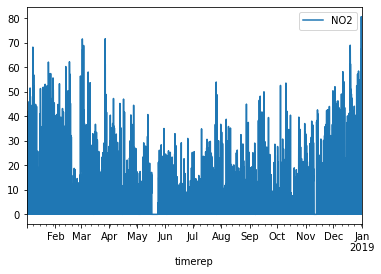

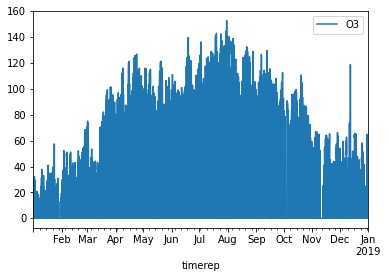

In [26]:
# now plot data
df.plot(y=['NO2'])
df.plot(y=['O3'])

Check out yourself how the plots for NO<sub>2</sub>, O<sub>3</sub>, PM<sub>10</sub> and PM<sub>2.5</sub> look like, using the original data set, i.e. without removing the -999 values.

### Resampling data

In [27]:
# check how resample() works, aggregating by day, then computing the mean of the resampled values for the PM25 column.
df.resample('D').mean()[['PM25']]

PM25
timerep              
2018-01-01  11.749860
2018-01-02  11.192082
2018-01-03  18.430444
2018-01-04  17.345337
2018-01-05  18.981495
...               ...
2018-12-28  43.645284
2018-12-29  35.085193
2018-12-30  36.215245
2018-12-31  21.952730
2019-01-01  21.329750

[366 rows x 1 columns]

In [28]:
# find all days where PM10>50. The following line does the following:
# 1) resample by day
# 2) take the mean
# 3) perform a query with the condition to get only the rows where the PM10 value is > 50
# 4) show only the PM10 column
df.resample('D').mean().query('PM10>50')[['PM10']]

PM10
timerep              
2018-01-08  58.075001
2018-01-25  60.983334
2018-01-26  52.020825
2018-04-16  52.054168
2018-04-17  54.837502
2018-11-30  55.775001
2018-12-02  56.258334
2018-12-27  50.329159
2018-12-28  67.591669
2018-12-29  52.487492
2018-12-30  50.937501

In [29]:
# find all days where PM25>24
df.resample('D').mean().query('PM25>24')[['PM25']]

PM25
timerep              
2018-01-07  31.444522
2018-01-08  32.166135
2018-01-25  32.424501
2018-01-26  30.520891
2018-01-29  29.445154
2018-01-30  25.206212
2018-02-16  24.072378
2018-04-16  27.824665
2018-04-17  27.290950
2018-10-29  24.909322
2018-11-23  32.190535
2018-11-30  32.365248
2018-12-01  28.190742
2018-12-02  34.407870
2018-12-19  26.808877
2018-12-27  34.304445
2018-12-28  43.645284
2018-12-29  35.085193
2018-12-30  36.215245

In [30]:
# find the yearly PM10 mean: resample by year, using the argument 'A'
df.resample('A').mean()[['PM10']]

PM10
timerep              
2018-12-31  20.273660
2019-12-31  42.200001

In [31]:
# let's get just the first entry:
df.resample('A').mean()[['PM10']].head(1)

PM10
timerep             
2018-12-31  20.27366

In [32]:
# find the yearly PM25 mean, resampling by year
df.resample('A').mean()[['PM25']]

PM25
timerep              
2018-12-31  11.179227
2019-12-31  21.329750

In [33]:
# again, let's get just the first entry:
df.resample('A').mean()[['PM25']].head(1)

PM25
timerep              
2018-12-31  11.179227

### Saving to SQLite and reading the DB back

In [34]:
# close the previous connection before moving on.
conn.close()

In [35]:
# write the data frame to a new SQLite database
conn = sql.connect('gubbio_env_2018_custom.sqlite')
df.to_sql('gubbio', conn, if_exists='replace')
conn.close()

In [36]:
# read it back
conn = sql.connect('gubbio_env_2018_custom.sqlite')
df2 = pd.read_sql('SELECT * FROM gubbio', conn)
conn.close()

In [37]:
# check what the data frame looks like
df2.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   timerep  8760 non-null   object 
 1   year     8760 non-null   int64  
 2   month    8760 non-null   int64  
 3   day      8760 non-null   int64  
 4   hour     8760 non-null   int64  
 5   NO2      8760 non-null   float64
 6   O3       8760 non-null   float64
 7   PM10     8760 non-null   float64
 8   PM25     8760 non-null   float64
dtypes: float64(4), int64(4), object(1)
memory usage: 1.2 MB


<AxesSubplot:>

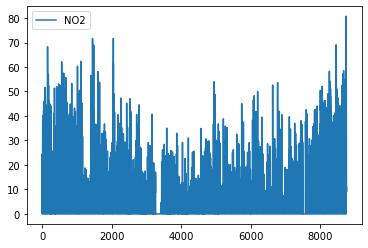

In [38]:
# the x-axis does not look right...
df2.plot(y=['NO2'])

In [39]:
# write the data frame to a new SQLite database again,
# but this time tell pandas to write an index to the DB
conn = sql.connect('gubbio_env_2018_custom.sqlite')
df.to_sql('gubbio', conn, if_exists='replace', index=True, index_label='timerep')
conn.close()

In [40]:
# read it back, but this time tell pandas that there is
# an index in the column 'timerep', of type datetime
conn = sql.connect('gubbio_env_2018_custom.sqlite')
df2 = pd.read_sql('SELECT * FROM gubbio', conn, index_col='timerep', parse_dates=['timerep'])
conn.close()

In [41]:
# check what the data frame looks like now
df2.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 01:00:00 to 2019-01-01 00:00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    8760 non-null   int64  
 1   month   8760 non-null   int64  
 2   day     8760 non-null   int64  
 3   hour    8760 non-null   int64  
 4   NO2     8760 non-null   float64
 5   O3      8760 non-null   float64
 6   PM10    8760 non-null   float64
 7   PM25    8760 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 615.9 KB


<AxesSubplot:xlabel='timerep'>

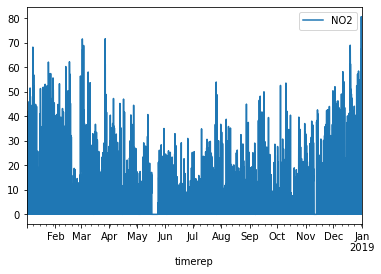

In [42]:
# the x-axis is now correct
df2.plot(y=['NO2'])